#### Imports & Downloads

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn import metrics

from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import cross_val_score

from src.functions.vectorize_functions import vectorize_tfidf, vectorize_glove, vectorize_w2v

### Model Preparation

#### Functions

In [2]:
def print_target_distribution(df, colname):
    positive = np.count_nonzero(df[colname] == 1)
    negative = np.count_nonzero(df[colname] == 0)
    print("- Positive:", positive)
    print("- Negative:", negative)
    print("- Verhältnis:", negative / positive)

In [3]:
evaluation = pd.DataFrame(
    columns=["model", "tuning", "vec_variant", "train_acc", "train_prec", "train_rec", "train_f1", "test_acc",
             "test_prec",
             "test_rec", "test_f1"])

In [4]:
def add_to_eval_df(model, model_name, tuning, vec_variant, x_data_train, y_data_train, x_data_test, y_data_test):
    train_acc = model.score(x_data_train, y_data_train)
    train_precision = precision_score(y_data_train, model.predict(x_data_train))
    train_recall = recall_score(y_data_train, model.predict(x_data_train))
    train_f1 = f1_score(y_data_train, model.predict(x_data_train))

    test_acc = model.score(x_data_test, y_data_test)
    test_precision = precision_score(y_data_test, model.predict(x_data_test))
    test_recall = recall_score(y_data_test, model.predict(x_data_test))
    test_f1 = f1_score(y_data_test, model.predict(x_data_test))

    evaluation.loc[len(evaluation.index)] = [model_name, tuning, vec_variant, train_acc, train_precision, train_recall,
                                             train_f1,
                                             test_acc, test_precision, test_recall, test_f1]

In [5]:
def evaluate_model(model, x_test, y_test):
    pred = model.predict(x_test)
    accscore = metrics.accuracy_score(pred, y_test)

    print(f'model accuracy for classification is =', str('{:04.2f}'.format(accscore * 100)) + '%')
    print('------------------------------------------------')
    print('Confusion Matrix:')
    print(pd.DataFrame(confusion_matrix(y_test, pred)))
    print('------------------------------------------------')
    print('Classification Report:')
    print(classification_report(y_test, pred))

    probs = model.predict_proba(x_test)
    preds = probs[:, 1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


#### Data Import

In [6]:
df_train_cleaned = pd.read_csv("..\\..\\..\\data\\new_datasets\\train_cleaned.csv")

In [7]:
print_target_distribution(df_train_cleaned, 'label')

- Positive: 13103
- Negative: 48155
- Verhältnis: 3.6751125696405404


In [8]:
df_train_cleaned = df_train_cleaned[df_train_cleaned.tweet_cleaned.notna()]
df_train_cleaned.isna().sum()

Unnamed: 0           0
tweet                0
label                0
tweet_cleaned        0
user_handle          0
hashtags             0
emojis           58161
dtype: int64

#### Vectorize - Word2Vec

In [9]:
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = vectorize_w2v(df=df_train_cleaned,
                                                                 text_column="tweet_cleaned",
                                                                 label_column="label")

#### Vectorize - TF-IDF

In [12]:
X_train_tf, X_test_tf, y_train_tf, y_test_tf = vectorize_tfidf(df=df_train_cleaned,
                                                               text_column="tweet_cleaned",
                                                               label_column="label")

#### Vectorize - Glove

In [13]:
X_train_gl, X_test_gl, y_train_gl, y_test_gl = vectorize_glove(df=df_train_cleaned,
                                                               text_column="tweet_cleaned",
                                                               label_column="label")

### Training Functions

In [14]:
def cross_validate_model(model, x_data, y_data, cv=10, scoring='f1'):
    cv = cross_val_score(model, x_data, y_data, cv=cv, scoring=scoring, verbose=10)
    print(f" MEAN: {np.mean(cv)}")

    return cv

#### 1.1 Bagging

##### 1.1.1 RandomForest

In [15]:
def train_randomforest(x_data, y_data):
    model = RandomForestClassifier(n_jobs=-1)
    model.fit(x_data, y_data)

    return model

In [16]:
def train_randomforest_tuned_randsearch(x_data, y_data):
    model = RandomForestClassifier(n_jobs=-1, max_depth=9, max_features=None, max_leaf_nodes=13)
    model.fit(x_data, y_data)

    return model

In [17]:
def train_randomforest_tuned_optuna(x_data, y_data):
    model = RandomForestClassifier(n_jobs=-1, n_estimators=450, max_depth=55, min_samples_split=4, min_samples_leaf=1)
    model.fit(x_data, y_data)

    return model

##### 1.1.2 BalancedRandomForest untuned

In [18]:
def train_balancedrandomforest(x_data, y_data):
    model = BalancedRandomForestClassifier(n_jobs=-1)
    model.fit(x_data, y_data)

    return model

In [19]:
# def train_balancedrandomforest_tuned(x_data, y_data):
#     model = BalancedRandomForestClassifier(n_jobs=-1, max_depth=9, max_features=None, max_leaf_nodes=13)
#     model.fit(x_data, y_data)
#
#     return model

#### 1.2 Boosting

##### 1.2.1 XGBClassifier

In [20]:
def train_xgboost(x_data, y_data):
    model = XGBClassifier(n_jobs=-1)
    model.fit(x_data, y_data)

    return model

In [21]:
def train_xgboost_tuned_gridsearch(x_data, y_data):
    model = XGBClassifier(learning_rate=0.1, n_estimators=200, max_depth=11, subsample=0.7, reg_alpha=0.01)
    model.fit(x_data, y_data)

    return model

In [22]:
def train_xgboost_tuned_randsearch(x_data, y_data):
    model = XGBClassifier(n_jobs=-1, subsample=0.5, reg_alpha=1, n_estimators=150, min_child_weight=1,
                          max_depth=7, learning_rate=0.1, gamma=0.4)
    model.fit(x_data, y_data)

    return model

In [23]:
def train_xgboost_tuned_optuna(x_data, y_data):
    model = XGBClassifier(n_jobs=-1, boost='gblinear', subsample=0.4736419905302216,
                          colsample_bytree=0.6711055768358083, alpha=8.528933855762793e-06)
    model.fit(x_data, y_data)

    return model

##### 1.2.1 CatBoostClassifier

In [24]:
def train_catboost(x_data, y_data):
    model = CatBoostClassifier(iterations=100,
                               depth=5,
                               learning_rate=0.1,
                               loss_function='Logloss',
                               verbose=True)
    model.fit(x_data, y_data)

    return model

##### 1.2.1 LGBMClassifier

In [25]:
def train_lightgbm(x_data, y_data):
    model = LGBMClassifier()
    model.fit(x_data, y_data)

    return model

#### 1.3 Stacking

##### 1.3.1 Stacking: RandomForest + LinearSVC

In [26]:
def train_stacking_rf_svm(x_data, y_data):
    base_models = [
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', LinearSVC(random_state=42))
    ]
    model = StackingClassifier(estimators=base_models, n_jobs=-1)
    model.fit(x_data, y_data)

    return model

In [27]:
def train_svc(x_data, y_data):
    model = LinearSVC()
    model.fit(x_data, y_data)

    return model

### Model Training

#### W2V

model accuracy for classification is = 80.74%
------------------------------------------------
Confusion Matrix:
       0    1
0  14207  252
1   3288  631
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.98      0.89     14459
           1       0.71      0.16      0.26      3919

    accuracy                           0.81     18378
   macro avg       0.76      0.57      0.58     18378
weighted avg       0.79      0.81      0.76     18378



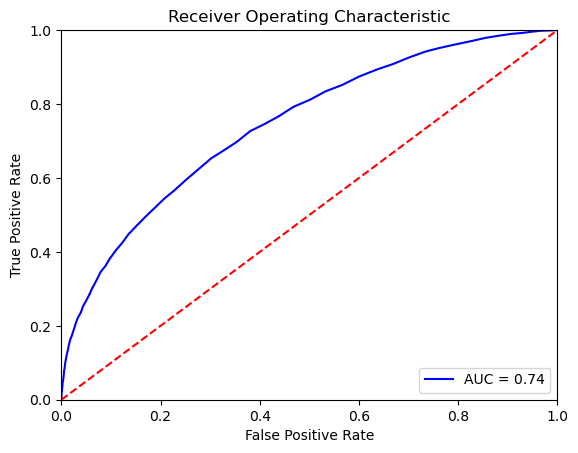

In [28]:
rf_untuned_w2v = train_randomforest(X_train_w2v, y_train_w2v)
evaluate_model(rf_untuned_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(rf_untuned_w2v, "RandomForest", "untuned", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

model accuracy for classification is = 79.23%
------------------------------------------------
Confusion Matrix:
       0    1
0  14410   49
1   3769  150
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.79      1.00      0.88     14459
           1       0.75      0.04      0.07      3919

    accuracy                           0.79     18378
   macro avg       0.77      0.52      0.48     18378
weighted avg       0.78      0.79      0.71     18378



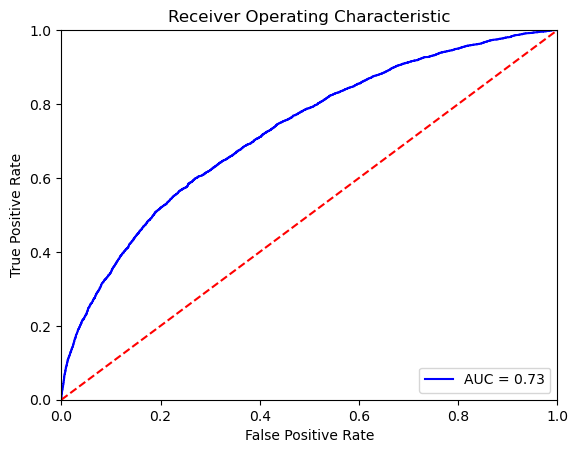

In [29]:
rf_rand_w2v = train_randomforest_tuned_randsearch(X_train_w2v, y_train_w2v)
evaluate_model(rf_rand_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(rf_rand_w2v, "RandomForest", "randsearch", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

model accuracy for classification is = 80.86%
------------------------------------------------
Confusion Matrix:
       0    1
0  14260  199
1   3318  601
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.99      0.89     14459
           1       0.75      0.15      0.25      3919

    accuracy                           0.81     18378
   macro avg       0.78      0.57      0.57     18378
weighted avg       0.80      0.81      0.75     18378



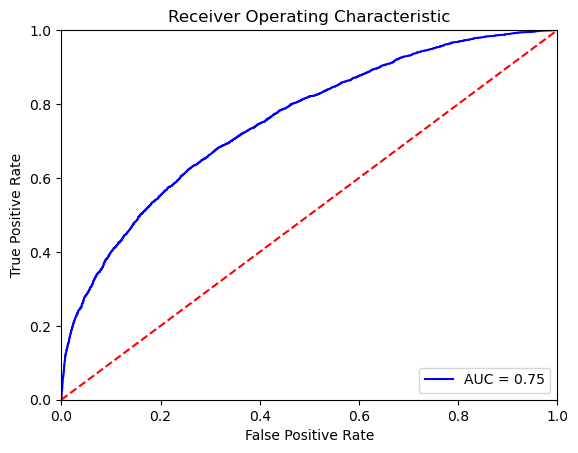

In [30]:
rf_optuna_w2v = train_randomforest_tuned_optuna(X_train_w2v, y_train_w2v)
evaluate_model(rf_optuna_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(rf_optuna_w2v, "RandomForest", "optuna", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.u

model accuracy for classification is = 72.09%
------------------------------------------------
Confusion Matrix:
       0     1
0  10545  3914
1   1216  2703
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.73      0.80     14459
           1       0.41      0.69      0.51      3919

    accuracy                           0.72     18378
   macro avg       0.65      0.71      0.66     18378
weighted avg       0.79      0.72      0.74     18378



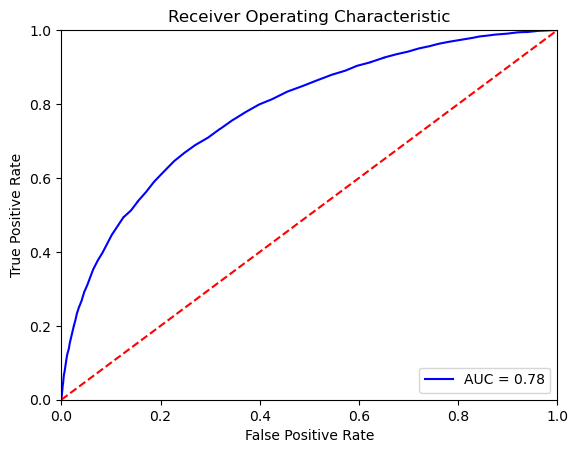

In [31]:
brf_untuned_w2v = train_balancedrandomforest(X_train_w2v, y_train_w2v)
evaluate_model(brf_untuned_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(brf_untuned_w2v, "BalancedRandomForest", "untuned", "w2v", X_train_w2v, y_train_w2v, X_test_w2v,
               y_test_w2v)

model accuracy for classification is = 81.02%
------------------------------------------------
Confusion Matrix:
       0     1
0  13617   842
1   2646  1273
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.94      0.89     14459
           1       0.60      0.32      0.42      3919

    accuracy                           0.81     18378
   macro avg       0.72      0.63      0.65     18378
weighted avg       0.79      0.81      0.79     18378



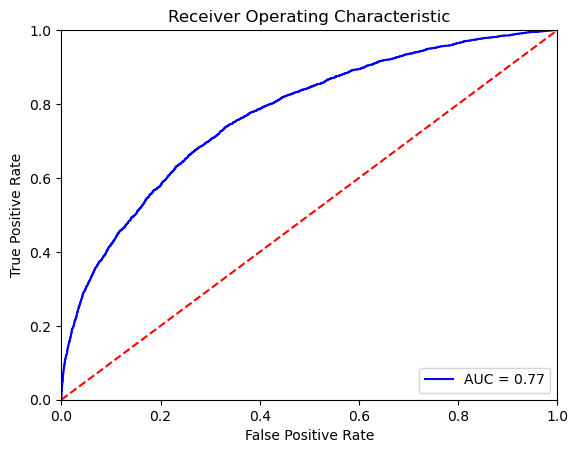

In [32]:
xgb_untuned_w2v = train_xgboost(X_train_w2v, y_train_w2v)
evaluate_model(xgb_untuned_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(xgb_untuned_w2v, "XGBoost", "untuned", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

model accuracy for classification is = 81.84%
------------------------------------------------
Confusion Matrix:
       0     1
0  13907   552
1   2786  1133
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.96      0.89     14459
           1       0.67      0.29      0.40      3919

    accuracy                           0.82     18378
   macro avg       0.75      0.63      0.65     18378
weighted avg       0.80      0.82      0.79     18378



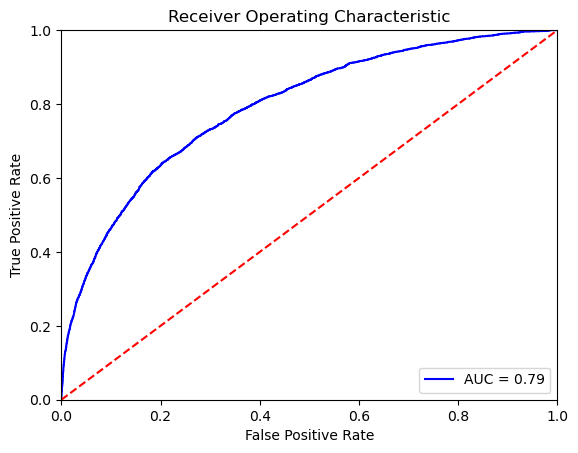

In [33]:
xgb_grid_w2v = train_xgboost_tuned_gridsearch(X_train_w2v, y_train_w2v)
evaluate_model(xgb_grid_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(xgb_grid_w2v, "XGBoost", "gridsearch", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

model accuracy for classification is = 81.48%
------------------------------------------------
Confusion Matrix:
       0     1
0  13750   709
1   2695  1224
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89     14459
           1       0.63      0.31      0.42      3919

    accuracy                           0.81     18378
   macro avg       0.73      0.63      0.65     18378
weighted avg       0.79      0.81      0.79     18378



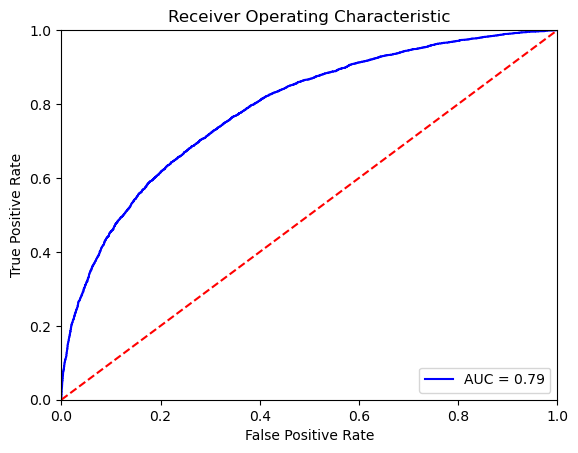

In [34]:
xgb_rand_w2v = train_xgboost_tuned_randsearch(X_train_w2v, y_train_w2v)
evaluate_model(xgb_rand_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(xgb_rand_w2v, "XGBoost", "randsearch", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

C:\Users\admin\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [22:58:06] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "boost" } are not used.

  warnings.warn(smsg, UserWarning)


model accuracy for classification is = 80.16%
------------------------------------------------
Confusion Matrix:
       0     1
0  13320  1139
1   2507  1412
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.92      0.88     14459
           1       0.55      0.36      0.44      3919

    accuracy                           0.80     18378
   macro avg       0.70      0.64      0.66     18378
weighted avg       0.78      0.80      0.79     18378



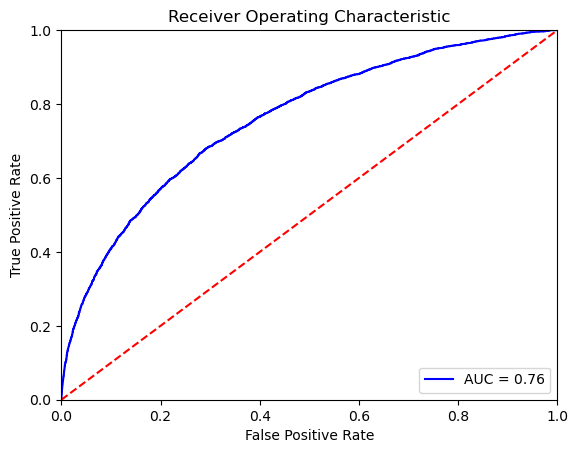

In [35]:
xgb_optuna_w2v = train_xgboost_tuned_optuna(X_train_w2v, y_train_w2v)
evaluate_model(xgb_optuna_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(xgb_optuna_w2v, "XGBoost", "optuna", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

0:	learn: 0.6540929	total: 195ms	remaining: 19.3s
1:	learn: 0.6199531	total: 241ms	remaining: 11.8s
2:	learn: 0.5936162	total: 284ms	remaining: 9.19s
3:	learn: 0.5722629	total: 330ms	remaining: 7.93s
4:	learn: 0.5553055	total: 376ms	remaining: 7.15s
5:	learn: 0.5403374	total: 418ms	remaining: 6.55s
6:	learn: 0.5284870	total: 462ms	remaining: 6.14s
7:	learn: 0.5184392	total: 507ms	remaining: 5.83s
8:	learn: 0.5099187	total: 547ms	remaining: 5.53s
9:	learn: 0.5024820	total: 590ms	remaining: 5.31s
10:	learn: 0.4961687	total: 634ms	remaining: 5.13s
11:	learn: 0.4911861	total: 676ms	remaining: 4.96s
12:	learn: 0.4869627	total: 720ms	remaining: 4.82s
13:	learn: 0.4831727	total: 763ms	remaining: 4.69s
14:	learn: 0.4797945	total: 806ms	remaining: 4.57s
15:	learn: 0.4766139	total: 850ms	remaining: 4.46s
16:	learn: 0.4737299	total: 896ms	remaining: 4.37s
17:	learn: 0.4715102	total: 942ms	remaining: 4.29s
18:	learn: 0.4691980	total: 987ms	remaining: 4.21s
19:	learn: 0.4670585	total: 1.03s	remaini

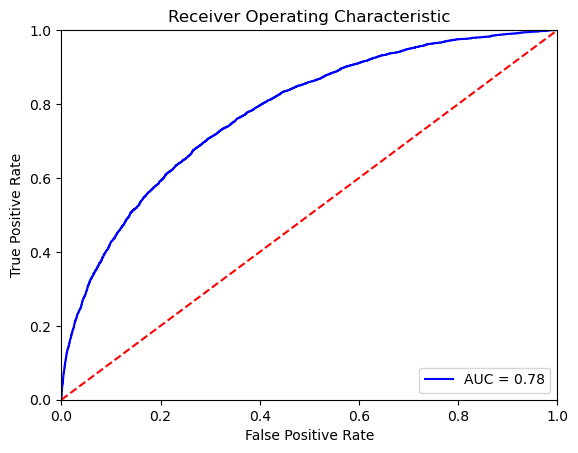

In [36]:
cat_untuned_w2v = train_catboost(X_train_w2v, y_train_w2v)
evaluate_model(cat_untuned_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(cat_untuned_w2v, "CatBoostClassifier", "untuned", "w2v", X_train_w2v, y_train_w2v, X_test_w2v,
               y_test_w2v)

[LightGBM] [Info] Number of positive: 9184, number of negative: 33695
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058827 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 42879, number of used features: 300
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.214184 -> initscore=-1.299887
[LightGBM] [Info] Start training from score -1.299887
model accuracy for classification is = 81.67%
------------------------------------------------
Confusion Matrix:
       0     1
0  13921   538
1   2830  1089
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.96      0.89     14459
           1       0.67      0.28      0.39      3919

    accuracy                           0.82     18378
   macro avg       0.75      0.62      0.64     18378
wei

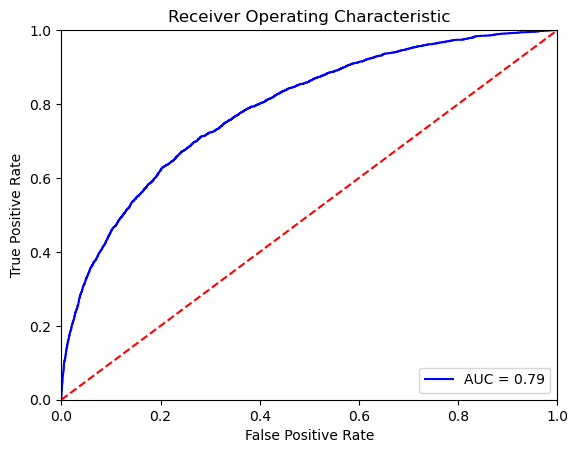

In [37]:
light_untuned_w2v = train_lightgbm(X_train_w2v, y_train_w2v)
evaluate_model(light_untuned_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(light_untuned_w2v, "LightGBM", "untuned", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

model accuracy for classification is = 80.99%
------------------------------------------------
Confusion Matrix:
       0    1
0  13924  535
1   2959  960
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.96      0.89     14459
           1       0.64      0.24      0.35      3919

    accuracy                           0.81     18378
   macro avg       0.73      0.60      0.62     18378
weighted avg       0.79      0.81      0.77     18378



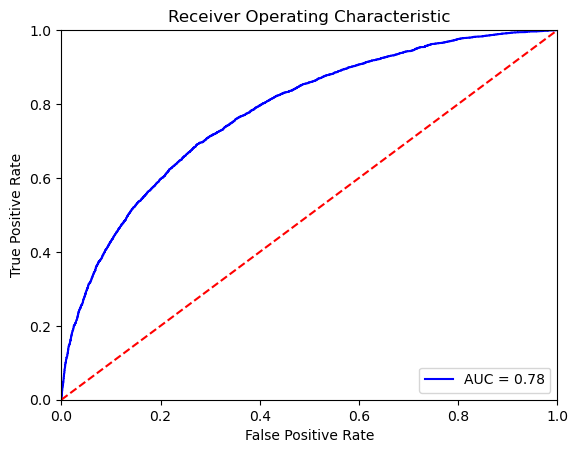

In [38]:
stack_untuned_w2v = train_stacking_rf_svm(X_train_w2v, y_train_w2v)
evaluate_model(stack_untuned_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(stack_untuned_w2v, "StackingClassifier-RF-SVC", "untuned", "w2v", X_train_w2v, y_train_w2v, X_test_w2v,
               y_test_w2v)

In [39]:
svc_untuned_w2v = train_svc(X_train_w2v, y_train_w2v)
add_to_eval_df(svc_untuned_w2v, "SVC", "untuned", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


#### TF-IDF

model accuracy for classification is = 82.15%
------------------------------------------------
Confusion Matrix:
       0     1
0  13993   466
1   2815  1104
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.97      0.90     14459
           1       0.70      0.28      0.40      3919

    accuracy                           0.82     18378
   macro avg       0.77      0.62      0.65     18378
weighted avg       0.80      0.82      0.79     18378



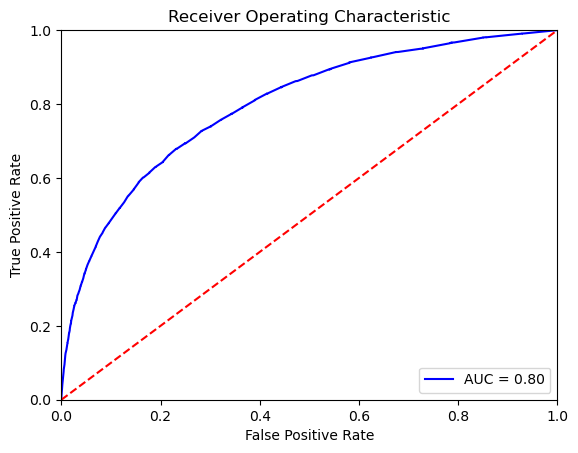

In [40]:
rf_untuned_tf = train_randomforest(X_train_tf, y_train_tf)
evaluate_model(rf_untuned_tf, X_test_tf, y_test_tf)
add_to_eval_df(rf_untuned_tf, "RandomForest", "untuned", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

model accuracy for classification is = 81.61%
------------------------------------------------
Confusion Matrix:
       0     1
0  13976   483
1   2896  1023
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.97      0.89     14459
           1       0.68      0.26      0.38      3919

    accuracy                           0.82     18378
   macro avg       0.75      0.61      0.63     18378
weighted avg       0.80      0.82      0.78     18378



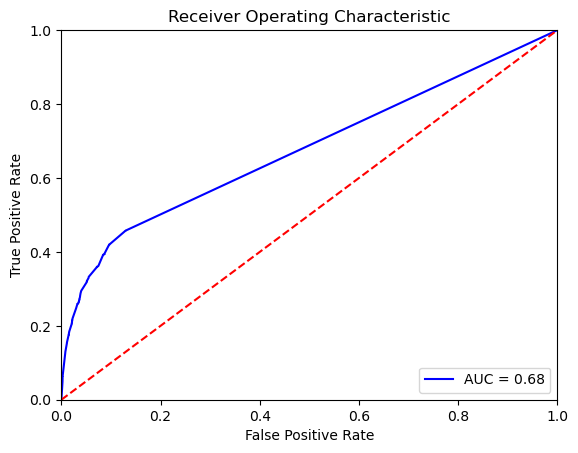

In [41]:
rf_rand_tf = train_randomforest_tuned_randsearch(X_train_tf, y_train_tf)
evaluate_model(rf_rand_tf, X_test_tf, y_test_tf)
add_to_eval_df(rf_rand_tf, "RandomForest", "randsearch", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

model accuracy for classification is = 79.77%
------------------------------------------------
Confusion Matrix:
       0    1
0  14436   23
1   3695  224
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89     14459
           1       0.91      0.06      0.11      3919

    accuracy                           0.80     18378
   macro avg       0.85      0.53      0.50     18378
weighted avg       0.82      0.80      0.72     18378



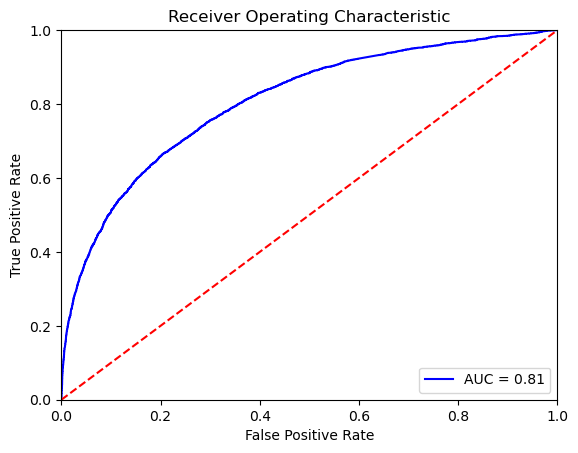

In [42]:
rf_optuna_tf = train_randomforest_tuned_optuna(X_train_tf, y_train_tf)
evaluate_model(rf_optuna_tf, X_test_tf, y_test_tf)
add_to_eval_df(rf_optuna_tf, "RandomForest", "optuna", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.u

model accuracy for classification is = 74.30%
------------------------------------------------
Confusion Matrix:
       0     1
0  10874  3585
1   1139  2780
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.75      0.82     14459
           1       0.44      0.71      0.54      3919

    accuracy                           0.74     18378
   macro avg       0.67      0.73      0.68     18378
weighted avg       0.81      0.74      0.76     18378



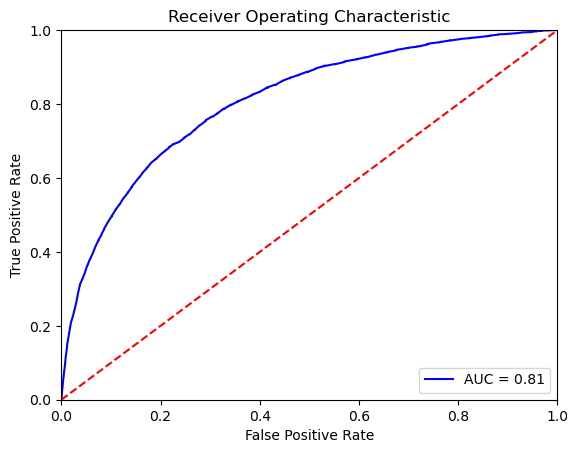

In [43]:
brf_untuned_tf = train_balancedrandomforest(X_train_tf, y_train_tf)
evaluate_model(brf_untuned_tf, X_test_tf, y_test_tf)
add_to_eval_df(brf_untuned_tf, "BalancedRandomForest", "untuned", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

model accuracy for classification is = 82.77%
------------------------------------------------
Confusion Matrix:
       0     1
0  13998   461
1   2705  1214
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.97      0.90     14459
           1       0.72      0.31      0.43      3919

    accuracy                           0.83     18378
   macro avg       0.78      0.64      0.67     18378
weighted avg       0.81      0.83      0.80     18378



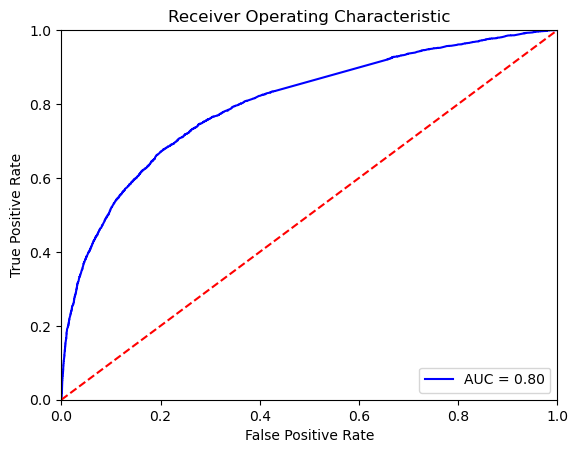

In [44]:
xgb_untuned_tf = train_xgboost(X_train_tf, y_train_tf)
evaluate_model(xgb_untuned_tf, X_test_tf, y_test_tf)
add_to_eval_df(xgb_untuned_tf, "XGBoost", "untuned", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

model accuracy for classification is = 82.91%
------------------------------------------------
Confusion Matrix:
       0     1
0  13922   537
1   2604  1315
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.96      0.90     14459
           1       0.71      0.34      0.46      3919

    accuracy                           0.83     18378
   macro avg       0.78      0.65      0.68     18378
weighted avg       0.81      0.83      0.80     18378



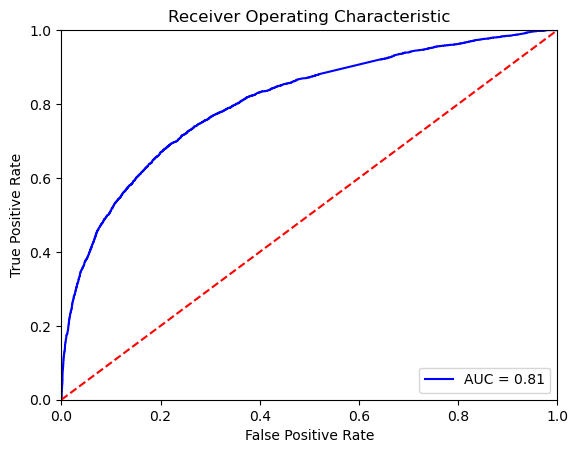

In [45]:
xgb_grid_tf = train_xgboost_tuned_gridsearch(X_train_tf, y_train_tf)
evaluate_model(xgb_grid_tf, X_test_tf, y_test_tf)
add_to_eval_df(xgb_grid_tf, "XGBoost", "gridsearch", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

model accuracy for classification is = 82.60%
------------------------------------------------
Confusion Matrix:
       0     1
0  14017   442
1   2756  1163
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.97      0.90     14459
           1       0.72      0.30      0.42      3919

    accuracy                           0.83     18378
   macro avg       0.78      0.63      0.66     18378
weighted avg       0.81      0.83      0.80     18378



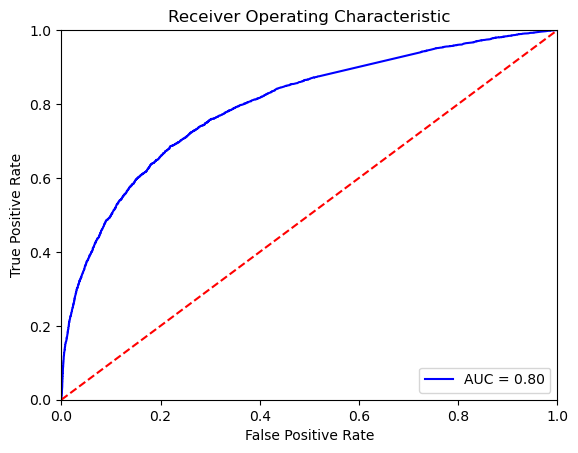

In [46]:
xgb_rand_tf = train_xgboost_tuned_randsearch(X_train_tf, y_train_tf)
evaluate_model(xgb_rand_tf, X_test_tf, y_test_tf)
add_to_eval_df(xgb_rand_tf, "XGBoost", "randsearch", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

C:\Users\admin\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:08:21] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "boost" } are not used.

  warnings.warn(smsg, UserWarning)


model accuracy for classification is = 82.60%
------------------------------------------------
Confusion Matrix:
       0     1
0  13875   584
1   2613  1306
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.96      0.90     14459
           1       0.69      0.33      0.45      3919

    accuracy                           0.83     18378
   macro avg       0.77      0.65      0.67     18378
weighted avg       0.81      0.83      0.80     18378



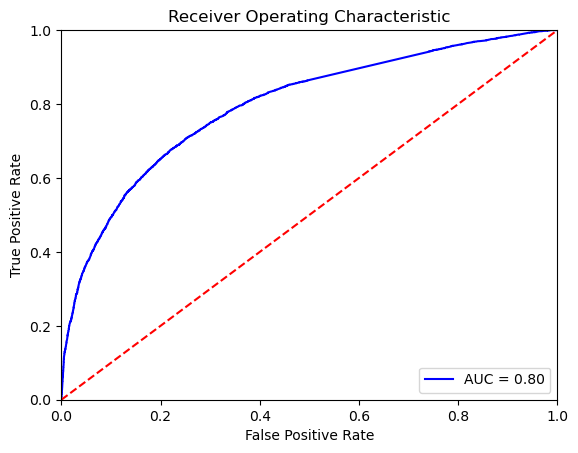

In [47]:
xgb_optuna_tf = train_xgboost_tuned_optuna(X_train_tf, y_train_tf)
evaluate_model(xgb_optuna_tf, X_test_tf, y_test_tf)
add_to_eval_df(xgb_optuna_tf, "XGBoost", "optuna", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

0:	learn: 0.6529031	total: 103ms	remaining: 10.2s
1:	learn: 0.6211461	total: 205ms	remaining: 10s
2:	learn: 0.5950023	total: 302ms	remaining: 9.77s
3:	learn: 0.5727107	total: 403ms	remaining: 9.66s
4:	learn: 0.5572375	total: 505ms	remaining: 9.59s
5:	learn: 0.5432046	total: 605ms	remaining: 9.49s
6:	learn: 0.5307686	total: 702ms	remaining: 9.33s
7:	learn: 0.5214806	total: 800ms	remaining: 9.2s
8:	learn: 0.5132130	total: 895ms	remaining: 9.04s
9:	learn: 0.5059916	total: 991ms	remaining: 8.91s
10:	learn: 0.5001601	total: 1.09s	remaining: 8.83s
11:	learn: 0.4952050	total: 1.19s	remaining: 8.71s
12:	learn: 0.4909213	total: 1.29s	remaining: 8.61s
13:	learn: 0.4875350	total: 1.39s	remaining: 8.51s
14:	learn: 0.4842737	total: 1.48s	remaining: 8.39s
15:	learn: 0.4815149	total: 1.58s	remaining: 8.3s
16:	learn: 0.4788510	total: 1.69s	remaining: 8.23s
17:	learn: 0.4765742	total: 1.78s	remaining: 8.13s
18:	learn: 0.4747001	total: 1.88s	remaining: 8.03s
19:	learn: 0.4729507	total: 1.98s	remaining: 

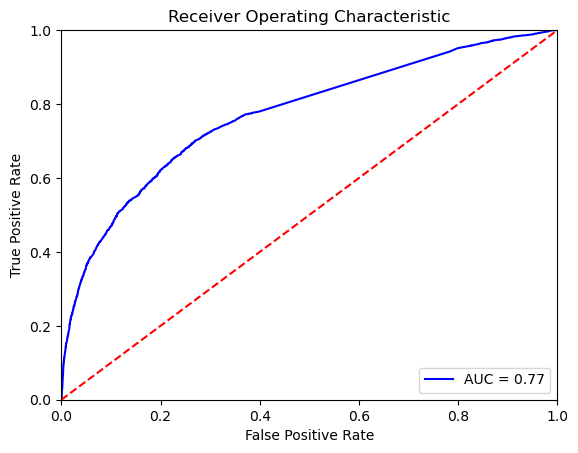

In [48]:
cat_untuned_tf = train_catboost(X_train_tf, y_train_tf)
evaluate_model(cat_untuned_tf, X_test_tf, y_test_tf)
add_to_eval_df(cat_untuned_tf, "CatBoostClassifier", "untuned", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

[LightGBM] [Info] Number of positive: 9184, number of negative: 33695
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.164247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 102961
[LightGBM] [Info] Number of data points in the train set: 42879, number of used features: 2746
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.214184 -> initscore=-1.299887
[LightGBM] [Info] Start training from score -1.299887
model accuracy for classification is = 82.75%
------------------------------------------------
Confusion Matrix:
       0     1
0  13950   509
1   2661  1258
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.96      0.90     14459
           1       0.71      0.32      0.44      3919

    accuracy                           0.83     18378
   macro avg       0.78      0.64      0.67     18378
w

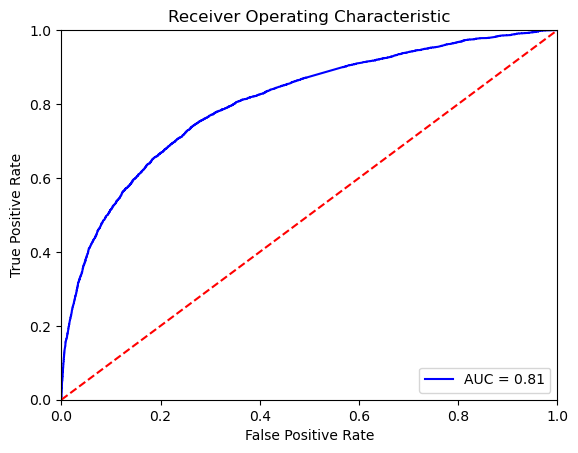

In [49]:
light_untuned_tf = train_lightgbm(X_train_tf, y_train_tf)
evaluate_model(light_untuned_tf, X_test_tf, y_test_tf)
add_to_eval_df(light_untuned_tf, "LightGBM", "untuned", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

model accuracy for classification is = 82.81%
------------------------------------------------
Confusion Matrix:
       0     1
0  13847   612
1   2548  1371
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.96      0.90     14459
           1       0.69      0.35      0.46      3919

    accuracy                           0.83     18378
   macro avg       0.77      0.65      0.68     18378
weighted avg       0.81      0.83      0.81     18378



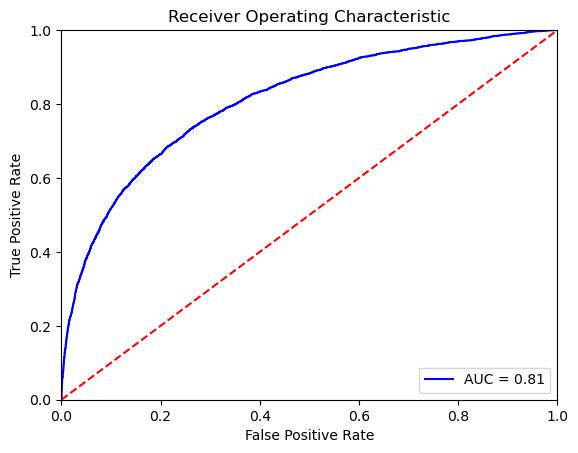

In [50]:
stack_untuned_tf = train_stacking_rf_svm(X_train_tf, y_train_tf)
evaluate_model(stack_untuned_tf, X_test_tf, y_test_tf)
add_to_eval_df(stack_untuned_tf, "StackingClassifier-RF-SVC", "untuned", "tf", X_train_tf, y_train_tf, X_test_tf,
               y_test_tf)

In [51]:
svc_untuned_tf = train_svc(X_train_tf, y_train_tf)
add_to_eval_df(svc_untuned_tf, "SVC", "untuned", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

#### Glove100d

model accuracy for classification is = 79.86%
------------------------------------------------
Confusion Matrix:
       0    1
0  14248  211
1   3491  428
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.99      0.89     14459
           1       0.67      0.11      0.19      3919

    accuracy                           0.80     18378
   macro avg       0.74      0.55      0.54     18378
weighted avg       0.77      0.80      0.74     18378



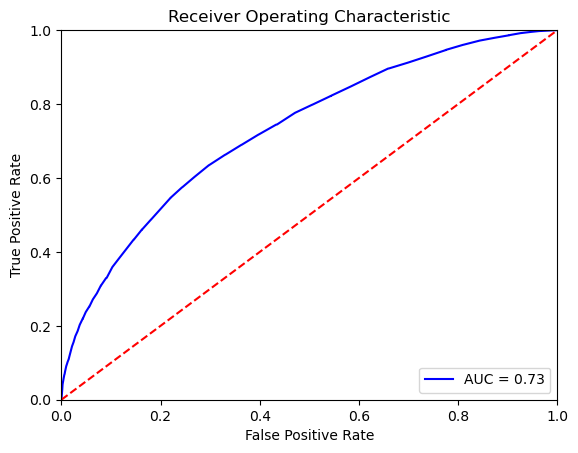

In [52]:
rf_untuned_gl = train_randomforest(X_train_gl, y_train_gl)
evaluate_model(rf_untuned_gl, X_test_gl, y_test_gl)
add_to_eval_df(rf_untuned_gl, "RandomForest", "untuned", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

model accuracy for classification is = 78.97%
------------------------------------------------
Confusion Matrix:
       0    1
0  14402   57
1   3808  111
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.79      1.00      0.88     14459
           1       0.66      0.03      0.05      3919

    accuracy                           0.79     18378
   macro avg       0.73      0.51      0.47     18378
weighted avg       0.76      0.79      0.71     18378



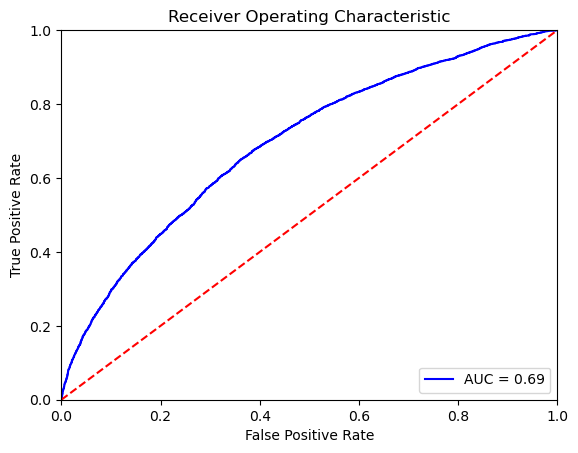

In [53]:
rf_rand_gl = train_randomforest_tuned_randsearch(X_train_gl, y_train_gl)
evaluate_model(rf_rand_gl, X_test_gl, y_test_gl)
add_to_eval_df(rf_rand_gl, "RandomForest", "randsearch", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

model accuracy for classification is = 80.05%
------------------------------------------------
Confusion Matrix:
       0    1
0  14278  181
1   3486  433
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.99      0.89     14459
           1       0.71      0.11      0.19      3919

    accuracy                           0.80     18378
   macro avg       0.75      0.55      0.54     18378
weighted avg       0.78      0.80      0.74     18378



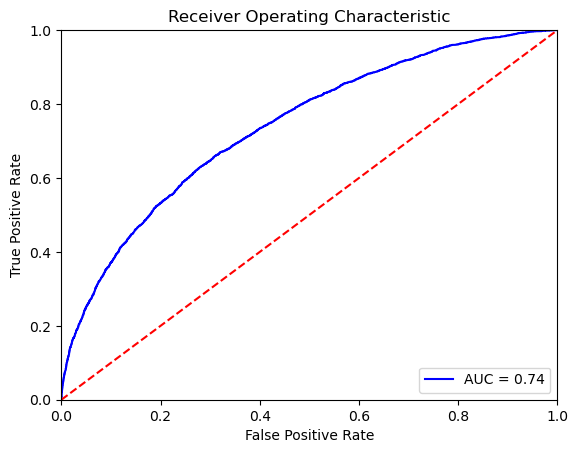

In [54]:
rf_optuna_gl = train_randomforest_tuned_optuna(X_train_gl, y_train_gl)
evaluate_model(rf_optuna_gl, X_test_gl, y_test_gl)
add_to_eval_df(rf_optuna_gl, "RandomForest", "optuna", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.u

model accuracy for classification is = 71.28%
------------------------------------------------
Confusion Matrix:
       0     1
0  10513  3946
1   1333  2586
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.73      0.80     14459
           1       0.40      0.66      0.49      3919

    accuracy                           0.71     18378
   macro avg       0.64      0.69      0.65     18378
weighted avg       0.78      0.71      0.73     18378



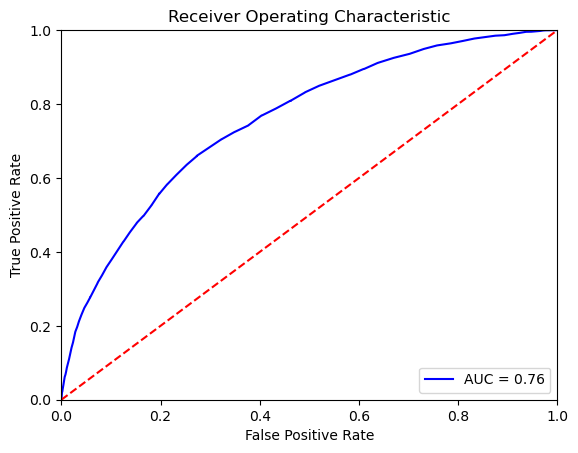

In [55]:
brf_untuned_gl = train_balancedrandomforest(X_train_gl, y_train_gl)
evaluate_model(brf_untuned_gl, X_test_gl, y_test_gl)
add_to_eval_df(brf_untuned_gl, "BalancedRandomForest", "untuned", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

model accuracy for classification is = 80.41%
------------------------------------------------
Confusion Matrix:
       0     1
0  13642   817
1   2783  1136
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.94      0.88     14459
           1       0.58      0.29      0.39      3919

    accuracy                           0.80     18378
   macro avg       0.71      0.62      0.64     18378
weighted avg       0.78      0.80      0.78     18378



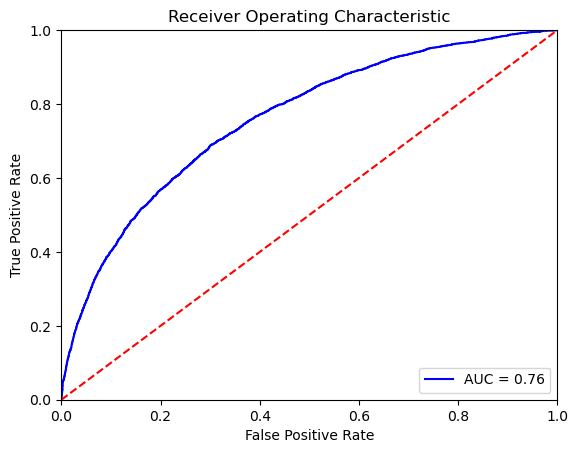

In [56]:
xgb_untuned_gl = train_xgboost(X_train_gl, y_train_gl)
evaluate_model(xgb_untuned_gl, X_test_gl, y_test_gl)
add_to_eval_df(xgb_untuned_gl, "XGBoost", "untuned", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

model accuracy for classification is = 81.25%
------------------------------------------------
Confusion Matrix:
       0     1
0  13926   533
1   2912  1007
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.96      0.89     14459
           1       0.65      0.26      0.37      3919

    accuracy                           0.81     18378
   macro avg       0.74      0.61      0.63     18378
weighted avg       0.79      0.81      0.78     18378



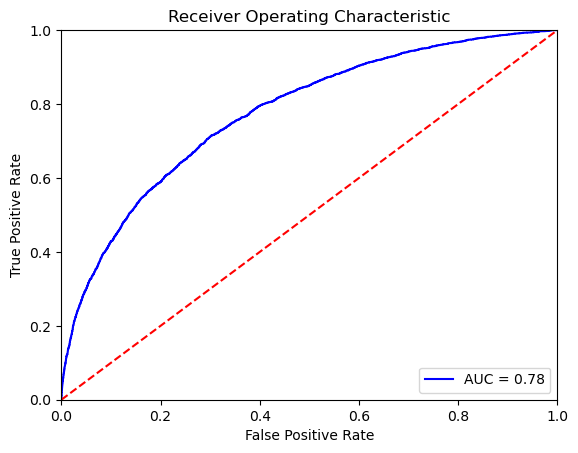

In [57]:
xgb_grid_gl = train_xgboost_tuned_gridsearch(X_train_gl, y_train_gl)
evaluate_model(xgb_grid_gl, X_test_gl, y_test_gl)
add_to_eval_df(xgb_grid_gl, "XGBoost", "gridsearch", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

model accuracy for classification is = 80.90%
------------------------------------------------
Confusion Matrix:
       0     1
0  13772   687
1   2824  1095
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.95      0.89     14459
           1       0.61      0.28      0.38      3919

    accuracy                           0.81     18378
   macro avg       0.72      0.62      0.64     18378
weighted avg       0.78      0.81      0.78     18378



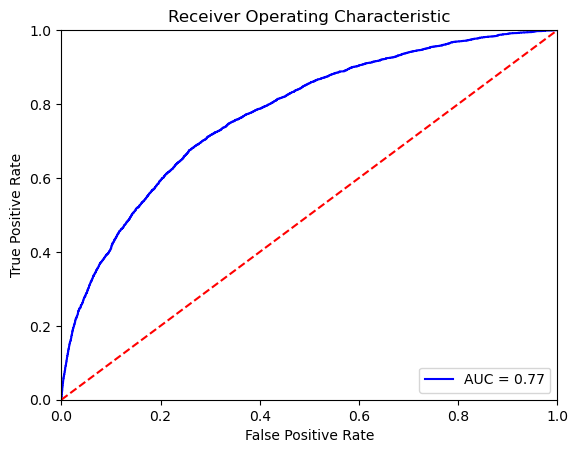

In [58]:
xgb_rand_gl = train_xgboost_tuned_randsearch(X_train_gl, y_train_gl)
evaluate_model(xgb_rand_gl, X_test_gl, y_test_gl)
add_to_eval_df(xgb_rand_gl, "XGBoost", "randsearch", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

C:\Users\admin\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [23:18:03] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "boost" } are not used.

  warnings.warn(smsg, UserWarning)


model accuracy for classification is = 79.31%
------------------------------------------------
Confusion Matrix:
       0     1
0  13340  1119
1   2684  1235
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.92      0.88     14459
           1       0.52      0.32      0.39      3919

    accuracy                           0.79     18378
   macro avg       0.68      0.62      0.63     18378
weighted avg       0.77      0.79      0.77     18378



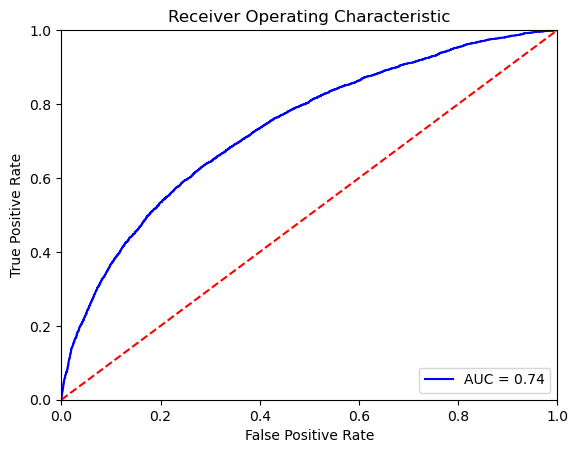

In [59]:
xgb_optuna_gl = train_xgboost_tuned_optuna(X_train_gl, y_train_gl)
evaluate_model(xgb_optuna_gl, X_test_gl, y_test_gl)
add_to_eval_df(xgb_optuna_gl, "XGBoost", "optuna", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

0:	learn: 0.6555567	total: 29.9ms	remaining: 2.96s
1:	learn: 0.6219014	total: 59.5ms	remaining: 2.91s
2:	learn: 0.5951343	total: 87ms	remaining: 2.81s
3:	learn: 0.5731545	total: 118ms	remaining: 2.83s
4:	learn: 0.5545928	total: 148ms	remaining: 2.81s
5:	learn: 0.5409164	total: 178ms	remaining: 2.79s
6:	learn: 0.5294704	total: 207ms	remaining: 2.75s
7:	learn: 0.5203669	total: 236ms	remaining: 2.72s
8:	learn: 0.5126102	total: 266ms	remaining: 2.69s
9:	learn: 0.5057233	total: 295ms	remaining: 2.66s
10:	learn: 0.5006708	total: 323ms	remaining: 2.62s
11:	learn: 0.4960348	total: 351ms	remaining: 2.57s
12:	learn: 0.4920602	total: 381ms	remaining: 2.55s
13:	learn: 0.4881078	total: 410ms	remaining: 2.52s
14:	learn: 0.4850348	total: 439ms	remaining: 2.49s
15:	learn: 0.4825068	total: 468ms	remaining: 2.46s
16:	learn: 0.4801479	total: 497ms	remaining: 2.43s
17:	learn: 0.4781515	total: 527ms	remaining: 2.4s
18:	learn: 0.4763184	total: 555ms	remaining: 2.37s
19:	learn: 0.4746670	total: 583ms	remaini

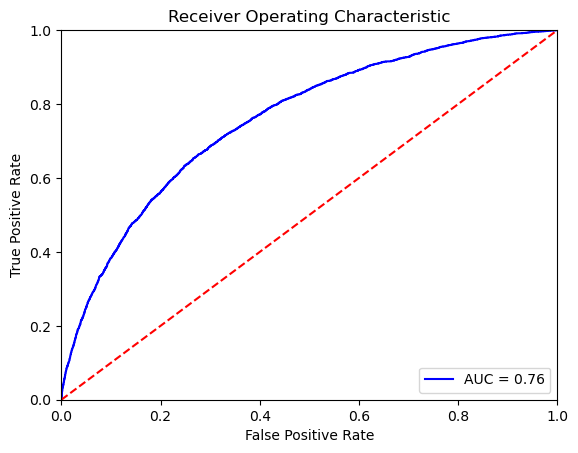

In [60]:
cat_untuned_gl = train_catboost(X_train_gl, y_train_gl)
evaluate_model(cat_untuned_gl, X_test_gl, y_test_gl)
add_to_eval_df(cat_untuned_gl, "CatBoostClassifier", "untuned", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

[LightGBM] [Info] Number of positive: 9184, number of negative: 33695
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 42879, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.214184 -> initscore=-1.299887
[LightGBM] [Info] Start training from score -1.299887
model accuracy for classification is = 80.69%
------------------------------------------------
Confusion Matrix:
       0    1
0  13933  526
1   3022  897
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.96      0.89     14459
           1       0.63      0.23      0.34      3919

    accuracy                           0.81     18378
   macro avg       0.73      0.60      0.61     18378
weight

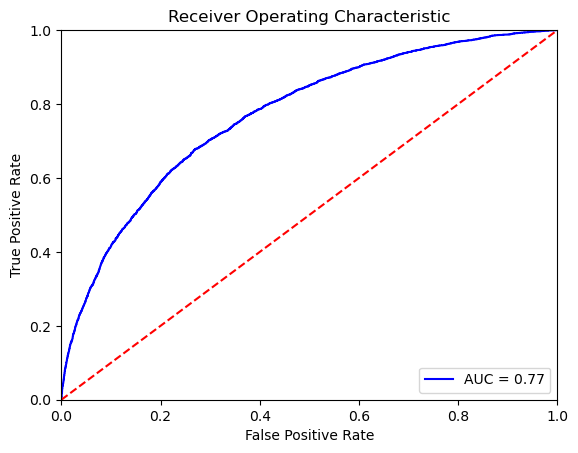

In [61]:
light_untuned_gl = train_lightgbm(X_train_gl, y_train_gl)
evaluate_model(light_untuned_gl, X_test_gl, y_test_gl)
add_to_eval_df(light_untuned_gl, "LightGBM", "untuned", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

model accuracy for classification is = 79.82%
------------------------------------------------
Confusion Matrix:
       0    1
0  13946  513
1   3195  724
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.96      0.88     14459
           1       0.59      0.18      0.28      3919

    accuracy                           0.80     18378
   macro avg       0.70      0.57      0.58     18378
weighted avg       0.76      0.80      0.75     18378



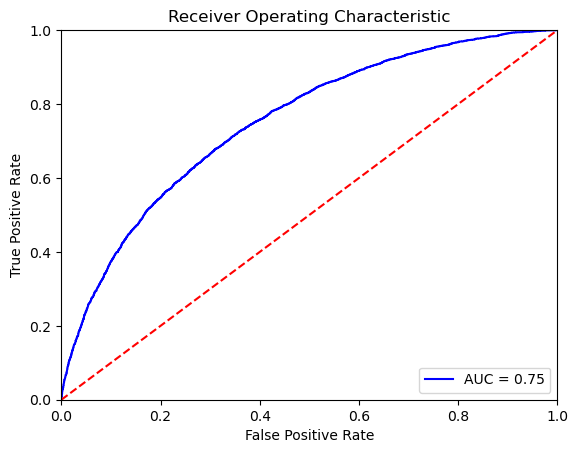

In [62]:
stack_untuned_gl = train_stacking_rf_svm(X_train_gl, y_train_gl)
evaluate_model(stack_untuned_gl, X_test_gl, y_test_gl)
add_to_eval_df(stack_untuned_gl, "StackingClassifier-RF-SVC", "untuned", "glove", X_train_gl, y_train_gl, X_test_gl,
               y_test_gl)

In [63]:
svc_untuned_gl = train_svc(X_train_gl, y_train_gl)
add_to_eval_df(svc_untuned_gl, "SVC", "untuned", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### Model evaluation

In [64]:
evaluation.sort_values(by=["test_f1"], ascending=False)

,model,tuning,vec_variant,train_acc,train_prec,train_rec,train_f1,test_acc,test_prec,test_rec,test_f1
15,BalancedRandomForest,untuned,tf,0.879755,0.640505,0.999673,0.780764,0.742954,0.436764,0.709365,0.540646
3,BalancedRandomForest,untuned,w2v,0.920451,0.729178,1.000000,0.843381,0.720862,0.408493,0.689717,0.513098
27,BalancedRandomForest,untuned,glove,0.914877,0.715666,0.999782,0.834196,0.712754,0.395897,0.659862,0.494881
23,SVC,untuned,tf,0.874671,0.818775,0.532774,0.645515,0.817717,0.616646,0.383771,0.473105
22,StackingClassifier-RF-SVC,untuned,tf,0.984468,0.986298,0.940549,0.962880,0.828055,0.691377,0.349834,0.464588
17,XGBoost,gridsearch,tf,0.859815,0.866991,0.408101,0.554971,0.829089,0.710043,0.335545,0.455727
19,XGBoost,optuna,tf,0.842230,0.781869,0.365309,0.497959,0.826042,0.691005,0.333248,0.449647
21,LightGBM,untuned,tf,0.843653,0.807387,0.354639,0.492813,0.827511,0.711941,0.321000,0.442490
7,XGBoost,optuna,w2v,0.922013,0.914420,0.701546,0.793962,0.801611,0.553508,0.360296,0.436476
16,XGBoost,untuned,tf,0.848061,0.842619,0.357361,0.501873,0.827729,0.724776,0.309773,0.434036
